<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/basics_04_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://arxiv.org/abs/1502.03167
- Hidden layer activation should not be too small or too large, best would be to be centered around 0 and have a std about ~ 1
- Idea: normalize the hidden state  to be gausian!

In [1]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-06-26 10:07:29--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2025-06-26 10:07:29 (7.90 MB/s) - ‘names.txt’ saved [228145/228145]



In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
# build vocab and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)

In [5]:
# build the dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd ** block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

In [7]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3022
  10000/ 200000: 2.2146
  20000/ 200000: 2.2256
  30000/ 200000: 2.4092
  40000/ 200000: 1.9429
  50000/ 200000: 2.4373
  60000/ 200000: 2.4328
  70000/ 200000: 2.1334
  80000/ 200000: 2.2828
  90000/ 200000: 2.1979
 100000/ 200000: 1.9310
 110000/ 200000: 2.2433
 120000/ 200000: 1.9741
 130000/ 200000: 2.5431
 140000/ 200000: 2.4108
 150000/ 200000: 2.2106
 160000/ 200000: 1.8690
 170000/ 200000: 1.7443
 180000/ 200000: 1.9653
 190000/ 200000: 1.8745


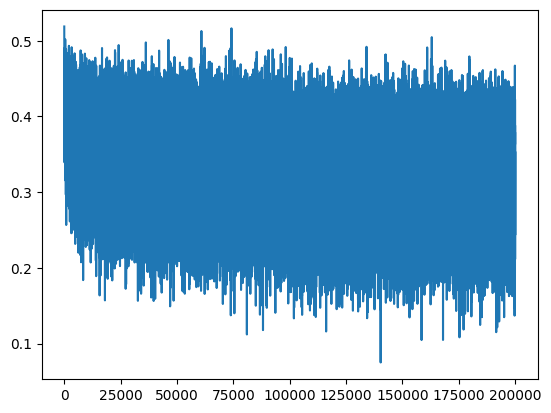

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad()
def calculate_loss(X, Y):
  emb = C[X]
  embcat =  emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss.item()

In [11]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
print(f"Training loss: {train_loss}")
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Dev loss: {dev_loss}")

Training loss: 2.086503028869629
Dev loss: 2.1310949325561523


# Normalize the activations
- calculate the batch mean and std
- Normalize the preactivation (preact - mean)/ std
- To make it more expressive gain*(preact - mean)/ std + bias, so the network can shift and scale the preactivations.


In [12]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd ** block_size)**0.5)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 12097


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1
  # Standardize the values
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0779
  20000/ 200000: 2.5788
  30000/ 200000: 1.8936
  40000/ 200000: 2.2461
  50000/ 200000: 1.7989
  60000/ 200000: 2.1059
  70000/ 200000: 2.4636
  80000/ 200000: 2.2951
  90000/ 200000: 2.1370
 100000/ 200000: 2.2995
 110000/ 200000: 2.3177
 120000/ 200000: 1.6240
 130000/ 200000: 1.9625
 140000/ 200000: 2.2112
 150000/ 200000: 1.9538
 160000/ 200000: 2.0463
 170000/ 200000: 2.4478
 180000/ 200000: 2.0624
 190000/ 200000: 2.1320


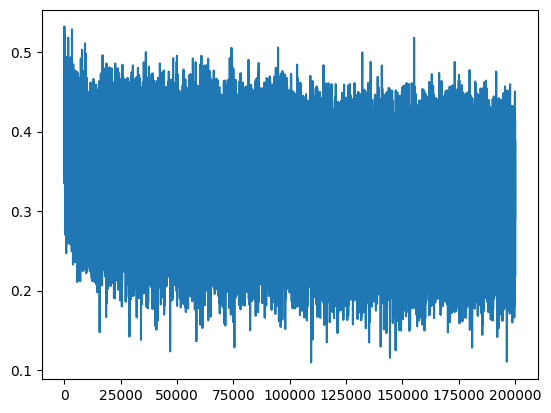

In [14]:
plt.plot(lossi)

In [15]:
@torch.no_grad()
def calculate_loss(X, Y):
  emb = C[X]
  embcat =  emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss.item()

In [16]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
print(f"Training loss: {train_loss}")
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Dev loss: {dev_loss}")

Training loss: 2.0594642162323
Dev loss: 2.1053507328033447


- Previously you arrived to the Logits through one example.
- For efficieny we used Batches that were processed indepentely
- Now with the Normalization the batches are coupled mathematically in the forward pass and backward pass.
- --> One activation is now not depended of one example, but on all the examples together, which change everytime.
- This is not a bug, but a feature:
  - This is a sideeffect, that regularizes the NN.
  - BUT if you want to sample from the Network, you need an std and mean, because in the forward pass the NN needs batches!

# Way 1: After Training

In [17]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd ** block_size)**0.5)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 12097


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1
  # Standardize the values
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0779
  20000/ 200000: 2.5788
  30000/ 200000: 1.8936
  40000/ 200000: 2.2461
  50000/ 200000: 1.7989
  60000/ 200000: 2.1059
  70000/ 200000: 2.4636
  80000/ 200000: 2.2951
  90000/ 200000: 2.1370
 100000/ 200000: 2.2995
 110000/ 200000: 2.3177
 120000/ 200000: 1.6240
 130000/ 200000: 1.9625
 140000/ 200000: 2.2112
 150000/ 200000: 1.9538
 160000/ 200000: 2.0463
 170000/ 200000: 2.4478
 180000/ 200000: 2.0624
 190000/ 200000: 2.1320


In [19]:
# calibarate the batch norm at the end of training
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [20]:
@torch.no_grad()
def calculate_loss(X, Y):
  emb = C[X]
  embcat =  emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss.item()

In [21]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
print(f"Training loss: {train_loss}")
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Dev loss: {dev_loss}")

Training loss: 2.0594642162323
Dev loss: 2.1055750846862793


# Way 2: Running Matter

In [22]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd ** block_size)**0.5)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 12097


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = (0.999 * bnmean_running) + (0.001 * bnmeani)
    bnstd_running = (0.999 * bnstd_running) + (0.001 * bnstdi)

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0779
  20000/ 200000: 2.5788
  30000/ 200000: 1.8936
  40000/ 200000: 2.2461
  50000/ 200000: 1.7989
  60000/ 200000: 2.1059
  70000/ 200000: 2.4636
  80000/ 200000: 2.2951
  90000/ 200000: 2.1370
 100000/ 200000: 2.2995
 110000/ 200000: 2.3177
 120000/ 200000: 1.6240
 130000/ 200000: 1.9625
 140000/ 200000: 2.2112
 150000/ 200000: 1.9538
 160000/ 200000: 2.0463
 170000/ 200000: 2.4478
 180000/ 200000: 2.0624
 190000/ 200000: 2.1320


In [24]:
@torch.no_grad()
def calculate_loss(X, Y):
  emb = C[X]
  embcat =  emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss.item()

In [25]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
print(f"Training loss: {train_loss}")
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Dev loss: {dev_loss}")

Training loss: 2.0594642162323
Dev loss: 2.1055750846862793


In [38]:
# Implementing the Code via Torch-like API
class Linear:
  def __init__(self,fan_in, fan_out, bias=True):
    self.weight = torch.randn(fan_in, fan_out) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out =  x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class Batch1DNorm:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.running_mean * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.running_mean * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [39]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]


with torch.no_grad():
  layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

In [40]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

46497


In [41]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

      0/ 200000: 3.3172


layer 1 (      Tanh): mean -0.05, std 0.74, saturated: 16.06%
layer 3 (      Tanh): mean -0.03, std 0.73, saturated: 12.81%
layer 5 (      Tanh): mean -0.01, std 0.73, saturated: 11.62%
layer 7 (      Tanh): mean -0.01, std 0.74, saturated: 11.59%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 10.16%


Text(0.5, 1.0, 'activation distribution')

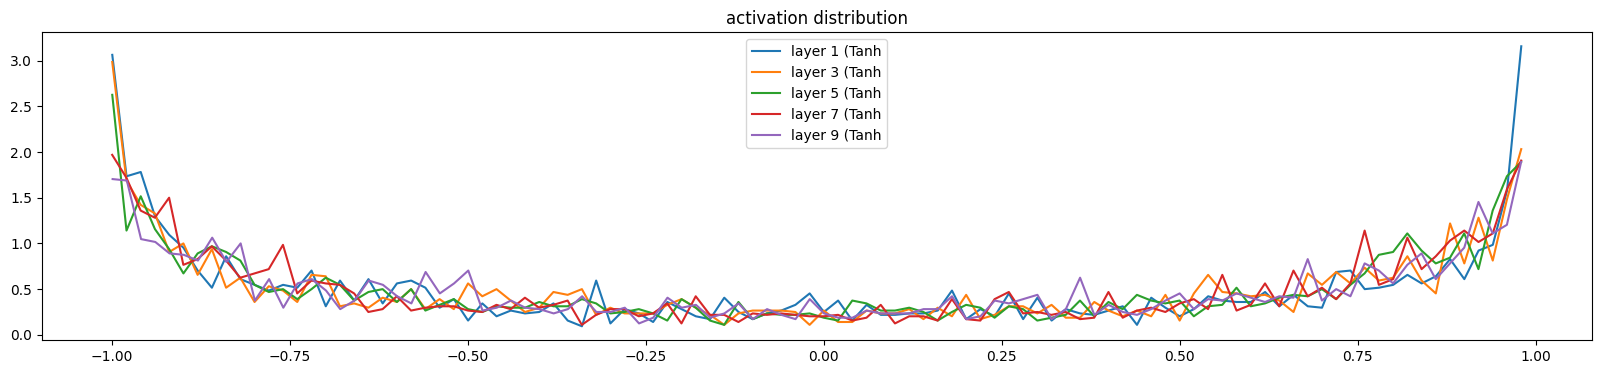

In [42]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000008, std 3.199722e-03
layer 3 (      Tanh): mean +0.000036, std 2.982432e-03
layer 5 (      Tanh): mean -0.000055, std 2.860961e-03
layer 7 (      Tanh): mean +0.000035, std 2.806537e-03
layer 9 (      Tanh): mean +0.000017, std 2.353859e-03


Text(0.5, 1.0, 'gradient distribution')

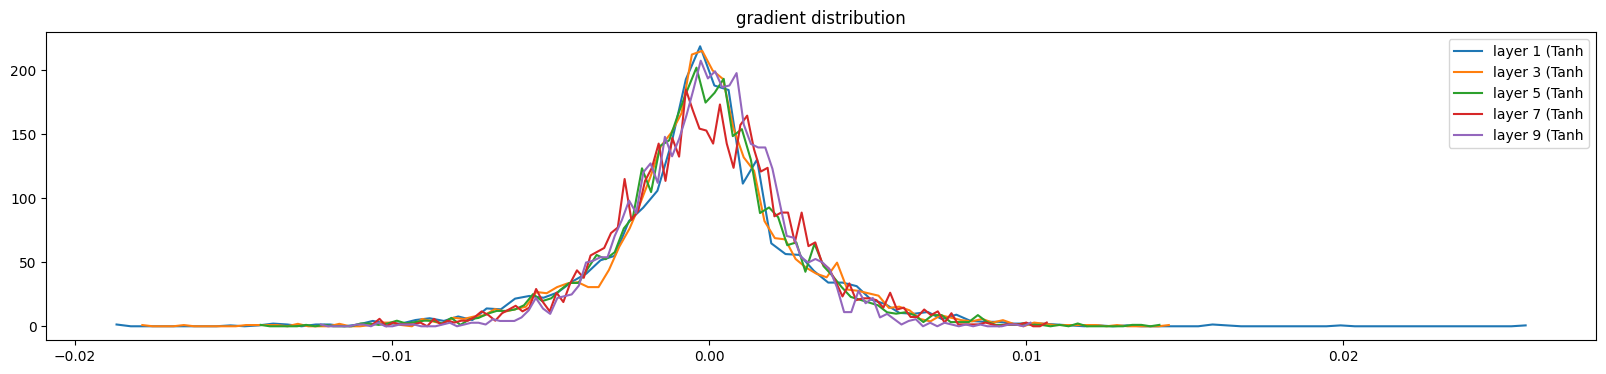

In [43]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.001812 | std 1.192528e-02 | grad:data ratio 1.191082e-02
weight  (30, 100) | mean +0.000017 | std 9.637620e-03 | grad:data ratio 3.128323e-02
weight (100, 100) | mean -0.000138 | std 7.486772e-03 | grad:data ratio 4.395075e-02
weight (100, 100) | mean +0.000062 | std 6.924181e-03 | grad:data ratio 4.129894e-02
weight (100, 100) | mean +0.000038 | std 6.067307e-03 | grad:data ratio 3.623312e-02
weight (100, 100) | mean +0.000025 | std 4.968188e-03 | grad:data ratio 2.960650e-02
weight  (100, 27) | mean +0.000000 | std 2.070076e-02 | grad:data ratio 3.003753e-01


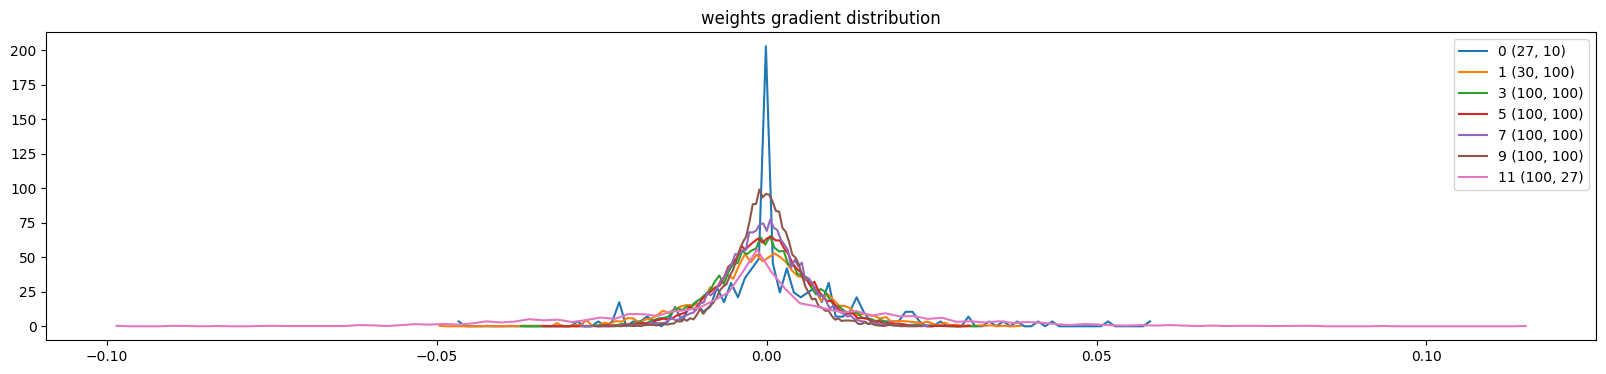

In [44]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

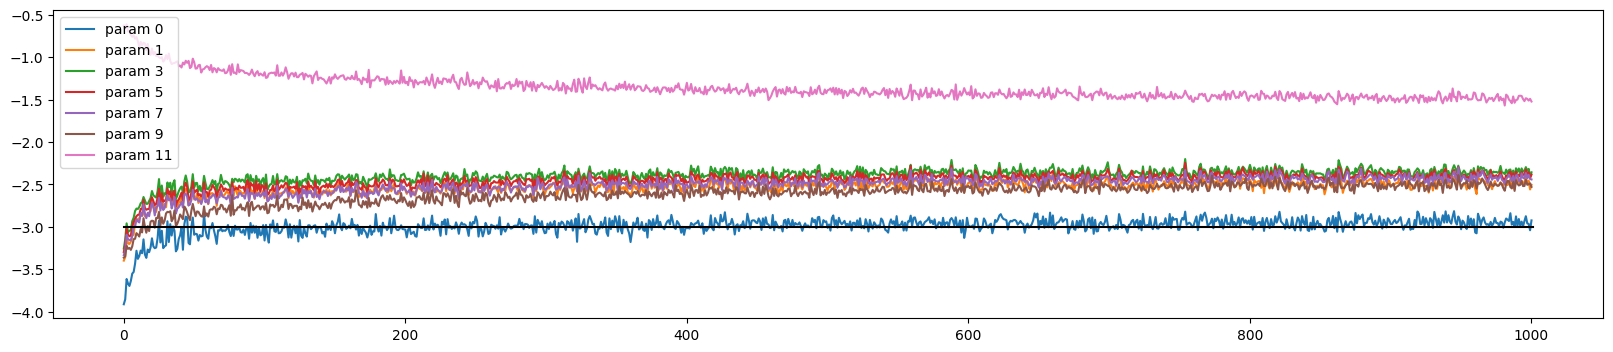

In [45]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);